Copyright (c) Microsoft Corporation. All rights reserved.

Licensed under the MIT License.

# This notebook creates the training script and runs it. It tests the model locally

In [5]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import pickle
import azureml.core
from azureml.core import Workspace
from sklearn.preprocessing import LabelEncoder
from keras.utils import np_utils
from azureml.core.compute import ComputeTarget, AmlCompute
from azureml.core.compute_target import ComputeTargetException
from azureml.core import Experiment

# check core SDK version number
print("Azure ML SDK Version: ", azureml.core.VERSION)

Azure ML SDK Version:  1.27.0


In [3]:
project_folder=os.getcwd()
data_folder='trainDataset'
script_folder='scripts' 
os.makedirs(script_folder, exist_ok=True)

Using TensorFlow backend.


Azure ML SDK Version:  1.27.0


### Connect to workspace

Create a workspace object from the existing workspace. `Workspace.from_config()` reads the file **config.json** and loads the details into an object named `ws`. Here we also create the object pointing to the default datastore 'ds'

In [6]:
# load workspace configuration from the config.json file in the current folder.
ws = Workspace.from_config()
ws = Workspace(subscription_id='ed940d3a-1d48-4740-b2cb-bd9fe6642e7b' ,resource_group='20191107_DNNhyperdrive', workspace_name = 'WS1' )

ds = ws.get_default_datastore()
print(ds.datastore_type, ds.account_name, ds.container_name)
print(ws.name, ws.location, ws.resource_group, ws.location, sep='\t')

AzureBlob ws11078562529 azureml-blobstore-15002b44-9629-4d8c-a66d-71dde33561ab
WS1	westeurope	20191107_DNNhyperdrive	westeurope


### Create experiment

Create an experiment to track the runs in your workspace. A workspace can have muliple experiments. 

In [7]:
experiment_name = 'ImageClassifier'
experiment = Experiment(workspace=ws, name=experiment_name)

### Create or Attach existing compute resource
By using Azure Machine Learning Compute, a managed service, data scientists can train machine learning models on clusters of Azure virtual machines. Examples include VMs with GPU support. In this tutorial, you create Azure Machine Learning Compute as your training environment. The code below creates the compute clusters for you if they don't already exist in your workspace.

**Creation of compute takes approximately 5 minutes.** If the AmlCompute with that name is already in your workspace the code will skip the creation process.

In [8]:
cluster_name = "gpucluster"

try:
    compute_target = ComputeTarget(workspace=ws, name=cluster_name)
    print('Found existing compute target')
except ComputeTargetException:
    print('Creating a new compute target...')
    compute_config = AmlCompute.provisioning_configuration(vm_size='STANDARD_NC6',
                                                           min_nodes=0,
                                                           max_nodes=4)

    compute_target = ComputeTarget.create(ws, cluster_name, compute_config)
    compute_target.wait_for_completion(show_output=True, min_node_count=None, timeout_in_minutes=20)

Found existing compute target


### Upload data to the cloud

### Preparation for the model

In [9]:
with open(os.path.join('trainDataset', "x_train.tsv"),"rb") as f:
     x_train=pickle.load(f)
with open(os.path.join('trainDataset', "x_val.tsv"),"rb") as f:
     x_val=pickle.load(f)
ntrain=len(x_train)
nval=len(x_val)
batch_size=32

In [10]:
%%writefile $script_folder/train.py
import argparse
import os
import numpy as np
import pickle
#from azureml.core.run import Run
from keras import layers, models, optimizers
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import EarlyStopping

parser = argparse.ArgumentParser()
parser.add_argument('--data-folder', type=str, dest='data_folder', help='data folder mounting point')
parser.add_argument('--batch-size', type=int, dest='batch_size', help='batch_size')
parser.add_argument('--layer-size', type=int, dest='layer_size', help='layer size multiplier')
parser.add_argument('--learning-rate', type=float, dest='learning_rate', default=0.001,  help='learning rate')


args = parser.parse_args()

data_folder = args.data_folder
print('Data folder:', data_folder)
batch_size = int(args.batch_size)
print('Batch size:', batch_size)
layer_size = int(args.layer_size)
print('Layer size:', layer_size)


with open(os.path.join(data_folder, 'x_train.tsv'),"rb") as f:
    x_train = pickle.load(f)
with open(os.path.join(data_folder,'y_train.tsv'),"rb") as f:
    y_train = pickle.load(f)
with open(os.path.join(data_folder,'x_val.tsv'),"rb") as f:
    x_val = pickle.load(f)
with open(os.path.join(data_folder,'y_val.tsv'),"rb") as f:
    y_val = pickle.load(f)

print(x_train.shape, y_train.shape, x_val.shape, y_val.shape, sep = '\n')

ntrain=len(x_train)
nval=len(x_val)


###################  modeling part

model=models.Sequential()
model.add(layers.Conv2D(32*layer_size,(3,3),activation='relu',input_shape=x_train[0].shape))
model.add(layers.MaxPooling2D((2,2)))

model.add(layers.Conv2D(64*layer_size,(3,3),activation='relu'))
model.add(layers.MaxPooling2D((2,2)))

model.add(layers.Conv2D(128*layer_size,(3,3),activation='relu'))
model.add(layers.MaxPooling2D((2,2)))

model.add(layers.Conv2D(128*layer_size,(3,3),activation='relu'))
model.add(layers.MaxPooling2D((2,2)))

model.add(layers.Flatten())
model.add(layers.Dropout(0.5))
model.add(layers.Dense(512*layer_size,activation='relu'))
model.add(layers.Dense(8,activation='sigmoid'))

model.compile(loss='categorical_crossentropy', optimizer=optimizers.RMSprop(lr=1e-4), metrics=['accuracy'])

trainDataGen= ImageDataGenerator(
                    rescale=1.,
                    rotation_range=40,
                    width_shift_range=0.2,
                    height_shift_range=0.2,
                    shear_range=0.2,
                    zoom_range=0.2
                    )
valDataGen=ImageDataGenerator(rescale=1.)

trainGenerator=trainDataGen.flow(x_train,y_train,batch_size = batch_size)
valGenerator=valDataGen.flow(x_val,y_val,batch_size = batch_size)

early_stopping = EarlyStopping(monitor='val_loss', patience=2)
history=model.fit_generator(trainGenerator,
                            steps_per_epoch = ntrain//batch_size,
                            epochs = 32,
                            validation_data = valGenerator,
                            validation_steps = nval//batch_size,
                            callbacks=[early_stopping],
                            workers=3
                           )

# for now I am not using the output argument from the args
os.makedirs('./outputs/model', exist_ok=True)

# serialize NN architecture to JSON
model_json = model.to_json()
# save model JSON
with open('./outputs/model/model.json', 'w') as f:
    f.write(model_json)
# save model weights
model.save_weights('./outputs/model/model.h5')
print("model saved in ./outputs/model folder")

with open('./outputs/model/trainHistoryDict', 'wb') as f:
        pickle.dump(history.history, f)

Overwriting scripts/train.py


## Define the Environment to run the job

In [33]:
%%writefile ./scripts/conda_dependencies.yml

channels:
- conda-forge
dependencies:
- python=3.6.2
- pip:
  - azureml-defaults
  - tensorflow-gpu==2.0.0
  - keras<=2.3.1
  - matplotlib
  - winmltools

Overwriting ./scripts/conda_dependencies.yml


In [11]:
from azureml.core import Environment

keras_env = Environment.from_conda_specification(name='keras-env', file_path='./scripts/conda_dependencies.yml')

# Specify a GPU base image
#keras_env.docker.enabled = True
keras_env.docker.base_image = 'mcr.microsoft.com/azureml/openmpi3.1.2-cuda10.0-cudnn7-ubuntu18.04'
keras_env.register(ws)

{
    "databricks": {
        "eggLibraries": [],
        "jarLibraries": [],
        "mavenLibraries": [],
        "pypiLibraries": [],
        "rcranLibraries": []
    },
    "docker": {
        "arguments": [],
        "baseDockerfile": null,
        "baseImage": "mcr.microsoft.com/azureml/openmpi3.1.2-cuda10.0-cudnn7-ubuntu18.04",
        "baseImageRegistry": {
            "address": null,
            "password": null,
            "registryIdentity": null,
            "username": null
        },
        "enabled": false,
        "platform": {
            "architecture": "amd64",
            "os": "Linux"
        },
        "sharedVolumes": true,
        "shmSize": null
    },
    "environmentVariables": {
        "EXAMPLE_ENV_VAR": "EXAMPLE_VALUE"
    },
    "inferencingStackVersion": null,
    "name": "keras-env",
    "python": {
        "baseCondaEnvironment": null,
        "condaDependencies": {
            "channels": [
                "conda-forge"
            ],
            "

## Get Datasets

In [36]:
from azureml.core import Dataset
trainDataset = Dataset.get_by_name(ws,'trainDataset')
testDataset = Dataset.get_by_name(ws,'testDataset')

## Configure the run

In [37]:
from azureml.core.runconfig import DockerConfiguration
dc=DockerConfiguration(use_docker=True, shared_volumes=True, arguments=[], shm_size='2g')

In [74]:
from azureml.core import ScriptRunConfig

args = ['--data-folder', trainDataset.as_named_input('trainDatasetLHgray4D').as_mount(),
        '--batch-size', 64,
        '--layer-size', 1,
        '--learning-rate', 0.001]

src = ScriptRunConfig(source_directory=script_folder,
                      script='train.py',
                      arguments=args,
                      compute_target=compute_target,
                      environment=keras_env,
                      docker_runtime_config=dc)             

#### The snapshot will contain all files in the project folder except the ones in the file '.amlignore'. 
The total snapshot size can't be larger than 300Mb and so we exclude largert files and folders

In [23]:
%%writefile .amlignore
data
model
sourceData
Training
Testing
trainDataset
testDataset
dataLH
model_keras.h5
model_weights.h5
model_wieghts.h5
ARCH

Overwriting .amlignore


## Run the training job 

In [75]:
from azureml.core import ScriptRunConfig
from azureml.core.runconfig import MpiConfiguration


args = ['--data-folder', trainDataset.as_named_input('trainDataset').as_mount(),
        '--batch-size', 64,
        '--layer-size', 1,
        '--learning-rate', 0.001]

src = ScriptRunConfig(source_directory=script_folder,
                      script='train.py',
                      arguments=args,
                      compute_target=compute_target,
                      distributed_job_config=MpiConfiguration(process_count_per_node=1, node_count=4),
                      environment=keras_env)

In [ ]:
from azureml.train.dnn import TensorFlow


#### Submit the job to the cluster

In [76]:
run = experiment.submit(config=src)
run

Experiment,Id,Type,Status,Details Page,Docs Page
ImageClassifier,ImageClassifier_1619553005_648e7224,azureml.scriptrun,Preparing,Link to Azure Machine Learning studio,Link to Documentation


#### Monitor a remote run


In [77]:
from azureml.widgets import RunDetails
RunDetails(run).show()


_UserRunWidget(widget_settings={'childWidgetDisplay': 'popup', 'send_telemetry': True, 'log_level': 'INFO', 's…

In [45]:
print(compute_target.get_status().current_node_count)
print(compute_target.get_status().allocation_state)

0
Resizing


#### (Optional) you can download older run

In [55]:
from azureml.core import Run
 
run_id='ImageClassifier_1581001560_f197552d'
run=Run(experiment, run_id)

#### Artefacts from /output folder are uploaded to the Workspace

#### Download the model

In [56]:
# Create a model folder in the current directory
os.makedirs('./model', exist_ok=True)

for f in run.get_file_names():
    print(f)
    if f.startswith('outputs/model'):
        output_file_path = os.path.join('./model', f.split('/')[-1])
        print('Downloading from {} to {} ...'.format(f, output_file_path))
        run.download_file(name=f, output_file_path=output_file_path)

azureml-logs/20_image_build_log.txt
azureml-logs/55_azureml-execution-tvmps_20d14c493df6fdd8a6a6ae776420dd74fa1dbbf862238e2f6354d5ba136e5e26_d.txt
azureml-logs/55_azureml-execution-tvmps_52753e127ea3c81c10f7b76d487885f9d528558a7afbb70f8e39148b5c4108db_d.txt
azureml-logs/55_azureml-execution-tvmps_c2f85c7268e1edbac441dfbca385d64e81e20e892369d097d03aeea8d3d44add_d.txt
azureml-logs/55_azureml-execution-tvmps_ee20b0497ef51e0903856f1be280db09e6ffc7d56d8e3fd1feed30215ad83b71_d.txt
azureml-logs/65_job_prep-tvmps_20d14c493df6fdd8a6a6ae776420dd74fa1dbbf862238e2f6354d5ba136e5e26_d.txt
azureml-logs/65_job_prep-tvmps_52753e127ea3c81c10f7b76d487885f9d528558a7afbb70f8e39148b5c4108db_d.txt
azureml-logs/65_job_prep-tvmps_c2f85c7268e1edbac441dfbca385d64e81e20e892369d097d03aeea8d3d44add_d.txt
azureml-logs/65_job_prep-tvmps_ee20b0497ef51e0903856f1be280db09e6ffc7d56d8e3fd1feed30215ad83b71_d.txt
azureml-logs/70_driver_log_0.txt
azureml-logs/70_driver_log_1.txt
azureml-logs/70_driver_log_2.txt
azureml-logs/

In [57]:
from keras.models import model_from_json

# load json and create model
json_file = open('model/model.json', 'r')
loaded_model_json = json_file.read()
json_file.close()
loaded_model = model_from_json(loaded_model_json)

# load weights into new model
loaded_model.load_weights("model/model.h5")
print("Loaded model from disk")


Loaded model from disk


In [60]:
from keras import layers, models, optimizers
loaded_model.compile(loss='categorical_crossentropy', optimizer=optimizers.RMSprop(lr=1e-4), metrics=['accuracy'])
with open('model/trainHistoryDict',"rb") as f:
     history=pickle.load(f)

### Visualize

In [62]:
acc=history['accuracy']
val_acc=history['val_accuracy']
loss=history['loss']
val_loss=history['val_loss']
epochs = range(len(acc))

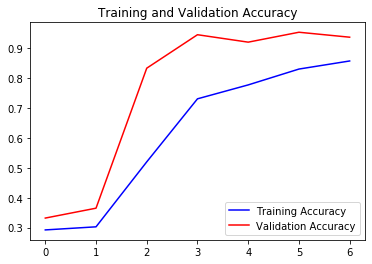

In [63]:
plt.plot(epochs,acc,'b',label='Training Accuracy')
plt.plot(epochs,val_acc,'r',label='Validation Accuracy')
plt.legend( loc="lower right")
plt.title('Training and Validation Accuracy')
plt.show()

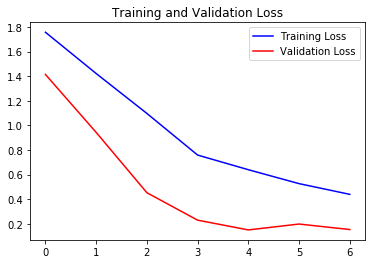

In [64]:
plt.plot(epochs,loss,'b',label='Training Loss')
plt.plot(epochs,val_loss,'r',label='Validation Loss')
plt.legend( loc="upper right")
plt.title('Training and Validation Loss')
plt.show()

### Test locally

In [65]:
with open(os.path.join('trainDataset', "x_train.tsv"),"rb") as f:
     x_train=pickle.load(f)
with open(os.path.join('trainDataset', "y_train.tsv"),"rb") as f:
     y_train=pickle.load(f)
with open(os.path.join('trainDataset', "x_val.tsv"),"rb") as f:
     x_val=pickle.load(f)
with open(os.path.join('trainDataset', "y_val.tsv"),"rb") as f:
     y_val=pickle.load(f)
with open(os.path.join('testDataset', "x_test.tsv"),"rb") as f:
     x_test=pickle.load(f)
with open(os.path.join('testDataset', "y_test.tsv"),"rb") as f:
     y_test=pickle.load(f)
with open(os.path.join('trainDataset', "encoder"),"rb") as f:
     encoder=pickle.load(f)

In [67]:
predicted=loaded_model.predict(x_test)
pred=[]
for p in predicted:
   # pred.append((p//np.amax(p)).astype(int))
    pred.append(np.argmax(p))
labelsText = encoder.inverse_transform(np.array(pred))
print(labelsText)

['4U' 'Background' '4U' '4U' '4U' 'Background' 'Background' 'Background'
 'EW' 'LH_new' 'LH_new' 'LH_new']


In [69]:
# Formatting the plot labels
sep=np.repeat('/',len(labelsText))
labelsValid=np.core.defchararray.add(np.core.defchararray.add(labelsText,sep),y_test)

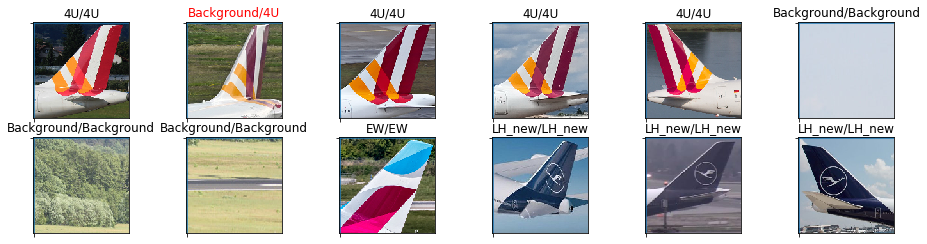

In [70]:
i=0
plt.figure(figsize = (16,6))

for p in range(len(predicted)):    
    imgData=x_test[p]
    
    plt.subplot(3, len(labelsText)//2, p+1)
    plt.axhline('')
    plt.axvline('')
    plt.imshow(imgData, cmap=plt.cm.Greys)
    title_obj=plt.title(labelsValid[p], fontsize=12)
    if (labelsText[p]!=y_test[p]):
        plt.setp(title_obj, color='r')         #set the color of title to red   
plt.show()

![Impressions](https://PixelServer20190423114238.azurewebsites.net/api/impressions/MachineLearningNotebooks/tutorials/img-classification-part1-training.png)

### Register the model
When the results of the model are satisfactory we can register it in Model Registry giving it a name and pointing to the folder where the model object is located 

In [71]:
# register model
model = run.register_model(model_name='DNNdemo',
                           model_path='outputs/model')
print(model.name, model.id, model.version, sep='\t')


DNNdemo	DNNdemo:1	1


#### Display registered models with versions

In [72]:
models = ws.models
for name, m in models.items():
    print("Name:", name,"\tVersion:", m.version, "\tDescription:", m.description, m.tags)

Name: onnxmodel 	Version: 1 	Description: None {}
Name: LHdemo 	Version: 1 	Description: None {}
Name: AutoML67c20ca3694 	Version: 1 	Description: None {}
Name: tf-dnn-mnist 	Version: 1 	Description: None {}
Name: DNNdemo 	Version: 1 	Description: None {}


#### Or retrieve an older registered model 

In [36]:
from azureml.core.model import Model
import os

older_model = Model(workspace=ws, name="demo", version=1)
older_model.download(target_dir=os.getcwd(),exist_ok=True)
older_model

Model(workspace=Workspace.create(name='DemoImages', subscription_id='ed940d3a-1d48-4740-b2cb-bd9fe6642e7b', resource_group='LufthansaZeroG'), name=LHdemo, id=LHdemo:4, version=4, tags={}, properties={})

# Next step
In the next chapter we will create simple deployment of the model usint Azure ML Service 